#Airline Data Challenge

by Mekhal Raj Rajendran

##Problem Statement
You are working for an airline company looking to enter the United States domestic market.
Specifically, the company has decided to start with 5 round trip routes between medium and
large US airports. An example of a round trip route is the combination of JFK to ORD and ORD
to JFK. The airline company has to acquire 5 new airplanes (one per round trip route) and the
upfront cost for each airplane is $90 million. The company’s motto is “On time, for you”, so
punctuality is a big part of its brand image.

##Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import geopy
from geopy.geocoders import Nominatim
!pip install airportsdata
import airportsdata
import seaborn as sns

##Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Please make sure that the link to the datasets are changed while loading the data if you're re-running the cells.

In [3]:
flights = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Flights.csv')
tickets = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tickets.csv')
airports = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Airport_Codes.csv')
metadata = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Airline_Challenge_Metadata.xlsx')

<ipython-input-3-83b923de1e65>:1: DtypeWarning: Columns (3,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Flights.csv')


Throughout the analysis, I'll be using reusable functions for analysis. It can be applied to other datasets too.

## Data Cleaning

In [4]:
#Creating a function that drops null values if it's less than 1% of the total data or else replace it with median.
def cleaning_data(df):
  df = df.drop_duplicates()
  total_rows = len(df)
  threshold = total_rows * 0.01
  missing_columns = df.columns[df.isnull().any()].tolist()
  missing_counts = df[missing_columns].isnull().sum()


  for column in missing_columns:
    try:
      df[column] = pd.to_numeric(df[column], errors='coerce')
    except ValueError:
      pass
    missing_count = missing_counts[column]
    # Checking if the column is numeric
    is_numeric = pd.api.types.is_numeric_dtype(df[column])

    # Counting non-numeric values in case of mixed data types
    if is_numeric:
        non_numeric_count = df[column].apply(lambda x: not pd.api.types.is_number(x) and pd.notnull(x)).sum()
        combined_null_count = missing_count + non_numeric_count
    else:
        combined_null_count = missing_count

    # Applying cleaning logic
    if combined_null_count < threshold:
        print('Dropping null values')
        df.dropna(subset=[column], inplace=True)
    else:
        if is_numeric:
            median_value = df[column].median()
            df[column] = df[column].fillna(median_value)

  return df

## Exploratory Data Analysis

Let's take a look at each of the datasets and so the necessary cleaning/transformation.

##Flights Dataset

In [5]:
flights

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-8.0,-6.0,0.0,143.0,1025.0,0.970000
1,2019-03-02,WN,N8686A,3231,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",1.0,5.0,0.0,135.0,930.0,0.550000
2,2019-03-02,WN,N201LV,3383,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",0.0,4.0,0.0,132.0,930.0,0.910000
3,2019-03-02,WN,N413WN,5498,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",11.0,14.0,0.0,136.0,930.0,0.670000
4,2019-03-02,WN,N7832A,6933,14635,RSW,"Fort Myers, FL",11259,DAL,"Dallas, TX",0.0,-17.0,0.0,151.0,1005.0,0.620000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915881,3/23/19,AA,N903NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-9.0,-6.0,0.0,112,****,0.794884
1915882,3/24/19,AA,N965AN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-2.0,-1.0,0.0,106,****,0.538399
1915883,3/25/19,AA,N979NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-8.0,-25.0,0.0,106,****,0.955579
1915884,3/26/19,AA,N872NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-9.0,-6.0,0.0,112,****,0.595344


###Let's take a look at the different datatypes.

In [6]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915886 entries, 0 to 1915885
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   FL_DATE            object 
 1   OP_CARRIER         object 
 2   TAIL_NUM           object 
 3   OP_CARRIER_FL_NUM  object 
 4   ORIGIN_AIRPORT_ID  int64  
 5   ORIGIN             object 
 6   ORIGIN_CITY_NAME   object 
 7   DEST_AIRPORT_ID    int64  
 8   DESTINATION        object 
 9   DEST_CITY_NAME     object 
 10  DEP_DELAY          float64
 11  ARR_DELAY          float64
 12  CANCELLED          float64
 13  AIR_TIME           object 
 14  DISTANCE           object 
 15  OCCUPANCY_RATE     float64
dtypes: float64(4), int64(2), object(10)
memory usage: 233.9+ MB


##Dropping Cancelled flights.

Let's drop all cancelled flights from our data since we're not considering it and it also makes the rest of the steps easier.

In [7]:
flights = flights[flights['CANCELLED'] == 0]
flights

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-8.0,-6.0,0.0,143.0,1025.0,0.970000
1,2019-03-02,WN,N8686A,3231,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",1.0,5.0,0.0,135.0,930.0,0.550000
2,2019-03-02,WN,N201LV,3383,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",0.0,4.0,0.0,132.0,930.0,0.910000
3,2019-03-02,WN,N413WN,5498,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",11.0,14.0,0.0,136.0,930.0,0.670000
4,2019-03-02,WN,N7832A,6933,14635,RSW,"Fort Myers, FL",11259,DAL,"Dallas, TX",0.0,-17.0,0.0,151.0,1005.0,0.620000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915881,3/23/19,AA,N903NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-9.0,-6.0,0.0,112,****,0.794884
1915882,3/24/19,AA,N965AN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-2.0,-1.0,0.0,106,****,0.538399
1915883,3/25/19,AA,N979NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-8.0,-25.0,0.0,106,****,0.955579
1915884,3/26/19,AA,N872NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-9.0,-6.0,0.0,112,****,0.595344


In [8]:
flights_missing_values = flights[['DEP_DELAY', 'ARR_DELAY', 'AIR_TIME', 'DISTANCE', 'OCCUPANCY_RATE']]
flights_missing_values

,DEP_DELAY,ARR_DELAY,AIR_TIME,DISTANCE,OCCUPANCY_RATE
0,-8.0,-6.0,143.0,1025.0,0.970000
1,1.0,5.0,135.0,930.0,0.550000
2,0.0,4.0,132.0,930.0,0.910000
3,11.0,14.0,136.0,930.0,0.670000
4,0.0,-17.0,151.0,1005.0,0.620000
...,...,...,...,...,...
1915881,-9.0,-6.0,112,****,0.794884
1915882,-2.0,-1.0,106,****,0.538399
1915883,-8.0,-25.0,106,****,0.955579
1915884,-9.0,-6.0,112,****,0.595344


###Visualizing the missing values

<ipython-input-9-b84eb540ade7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_missing_values[column] = pd.to_numeric(flights_missing_values[column], errors='coerce')
<ipython-input-9-b84eb540ade7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_missing_values[column] = pd.to_numeric(flights_missing_values[column], errors='coerce')
<ipython-input-9-b84eb540ade7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

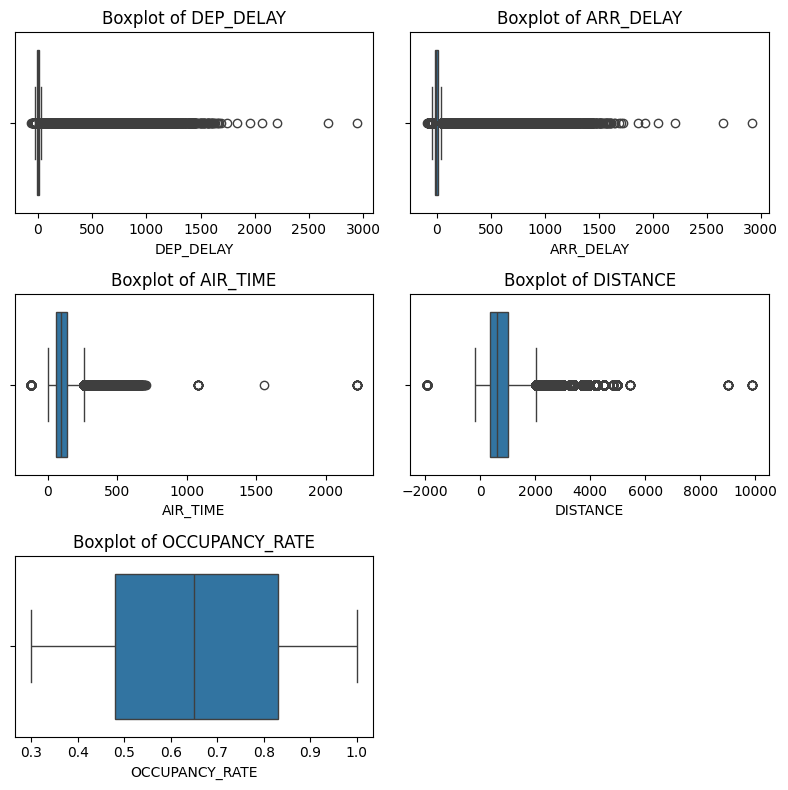

In [9]:
# Plotting separate boxplots for each column
num_cols = len(flights_missing_values.columns)
num_rows = (num_cols + 1) // 2

plt.figure(figsize=(8, 8))


for i, column in enumerate(flights_missing_values.columns):
    plt.subplot(num_rows, 2, i+1)
    flights_missing_values[column] = pd.to_numeric(flights_missing_values[column], errors='coerce')

    sns.boxplot(x=flights_missing_values[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

###Let's clean the data of any null values and make necessary conversions.

In [10]:
flights_clean = cleaning_data(flights)
print(flights_clean.info())

<ipython-input-4-db207bdc8bf9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_numeric(df[column], errors='coerce')


Dropping null values


<ipython-input-4-db207bdc8bf9>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=[column], inplace=True)
<ipython-input-4-db207bdc8bf9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_numeric(df[column], errors='coerce')


Dropping null values


<ipython-input-4-db207bdc8bf9>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=[column], inplace=True)
<ipython-input-4-db207bdc8bf9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_numeric(df[column], errors='coerce')


Dropping null values


<ipython-input-4-db207bdc8bf9>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=[column], inplace=True)
<ipython-input-4-db207bdc8bf9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_numeric(df[column], errors='coerce')


Dropping null values
<class 'pandas.core.frame.DataFrame'>
Index: 1855044 entries, 0 to 1910980
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   FL_DATE            object 
 1   OP_CARRIER         object 
 2   TAIL_NUM           object 
 3   OP_CARRIER_FL_NUM  object 
 4   ORIGIN_AIRPORT_ID  int64  
 5   ORIGIN             object 
 6   ORIGIN_CITY_NAME   object 
 7   DEST_AIRPORT_ID    int64  
 8   DESTINATION        object 
 9   DEST_CITY_NAME     object 
 10  DEP_DELAY          float64
 11  ARR_DELAY          float64
 12  CANCELLED          float64
 13  AIR_TIME           float64
 14  DISTANCE           float64
 15  OCCUPANCY_RATE     float64
dtypes: float64(6), int64(2), object(8)
memory usage: 240.6+ MB
None


<ipython-input-4-db207bdc8bf9>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=[column], inplace=True)


###Let's double-check that our data is clean.

In [11]:
print(flights_clean.isna().sum())
print(flights_clean.isnull().sum())

FL_DATE              0
OP_CARRIER           0
TAIL_NUM             0
OP_CARRIER_FL_NUM    0
ORIGIN_AIRPORT_ID    0
ORIGIN               0
ORIGIN_CITY_NAME     0
DEST_AIRPORT_ID      0
DESTINATION          0
DEST_CITY_NAME       0
DEP_DELAY            0
ARR_DELAY            0
CANCELLED            0
AIR_TIME             0
DISTANCE             0
OCCUPANCY_RATE       0
dtype: int64
FL_DATE              0
OP_CARRIER           0
TAIL_NUM             0
OP_CARRIER_FL_NUM    0
ORIGIN_AIRPORT_ID    0
ORIGIN               0
ORIGIN_CITY_NAME     0
DEST_AIRPORT_ID      0
DESTINATION          0
DEST_CITY_NAME       0
DEP_DELAY            0
ARR_DELAY            0
CANCELLED            0
AIR_TIME             0
DISTANCE             0
OCCUPANCY_RATE       0
dtype: int64


## Summary Statistics of the dataset.

In [12]:
def summarize_dataframe(df, head_rows=5):
    info_buffer = io.StringIO()
    df.info(buf = info_buffer)
    info_str = "\n".join(info_buffer)
    description = df.describe(include='all')
    preview = df.head(head_rows)
    return {
        'info': info_str,
        'describe': description,
        'head': preview
    }

In [13]:
flights_summary = summarize_dataframe(flights_clean)
print("Info:\n", flights_summary['info'])
print("\nDescribe:\n", flights_summary['describe'])
print("\nHead:\n", flights_summary['head'])

Info:
 

Describe:
            FL_DATE OP_CARRIER TAIL_NUM  OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID  \
count      1855044    1855044  1855044          1855044.0       1.855044e+06   
unique         119         26     6026             9069.0                NaN   
top     2019-03-29         WN   N485HA              546.0                NaN   
freq         23034     315918      928              851.0                NaN   
mean           NaN        NaN      NaN                NaN       1.268604e+04   
std            NaN        NaN      NaN                NaN       1.521634e+03   
min            NaN        NaN      NaN                NaN       1.013500e+04   
25%            NaN        NaN      NaN                NaN       1.129200e+04   
50%            NaN        NaN      NaN                NaN       1.288900e+04   
75%            NaN        NaN      NaN                NaN       1.405700e+04   
max            NaN        NaN      NaN                NaN       1.621800e+04   

         ORIGIN ORI

##Drop Columns

### Creating a function to drop columns that we don't require for analysis.

In [14]:
def drop_columns(df, columns_to_drop, inplace=False):

    return df.drop(columns=columns_to_drop, inplace=inplace)

In [15]:
columns_to_remove = ['OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', ]
flights_new = drop_columns(flights_clean, columns_to_remove, inplace=False)
print("Dataset after dropping specified columns:\n", flights_new)

Dataset after dropping specified columns:
             FL_DATE  ORIGIN_AIRPORT_ID ORIGIN ORIGIN_CITY_NAME  \
0        2019-03-02              14635    RSW   Fort Myers, FL   
1        2019-03-02              14635    RSW   Fort Myers, FL   
2        2019-03-02              14635    RSW   Fort Myers, FL   
3        2019-03-02              14635    RSW   Fort Myers, FL   
4        2019-03-02              14635    RSW   Fort Myers, FL   
...             ...                ...    ...              ...   
1910976     3/19/19              12478    JFK     New York, NY   
1910977     3/20/19              12478    JFK     New York, NY   
1910978     3/21/19              12478    JFK     New York, NY   
1910979     3/22/19              12478    JFK     New York, NY   
1910980     3/23/19              12478    JFK     New York, NY   

         DEST_AIRPORT_ID DESTINATION DEST_CITY_NAME  DEP_DELAY  ARR_DELAY  \
0                  11042         CLE  Cleveland, OH       -8.0       -6.0   
1         

##Check for Duplicates.

In [16]:
def check_duplicates(df):

    duplicate_count = df.duplicated().sum()

    duplicate_rows = df[df.duplicated(keep=False)]

    return {
        'duplicate_count': duplicate_count,
        'duplicate_rows': duplicate_rows
    }

In [17]:
duplicates_info = check_duplicates(flights_clean)
print("Number of Duplicate Rows:", duplicates_info['duplicate_count'])

Number of Duplicate Rows: 0


##Filtering Distance column.

###Let's remove the outliers in the distance. We're gonna exclude any flight routes with distance below 30 miles (since we're a commercial airline) and any above 5100 miles since US's longest nonstop domestic passenger service Hawaiian's Honoulu-Boston route is 5,095-miles.

In [18]:
def filter_column_in_range(df, column_name, min_value, max_value):

    filtered_df = df[(df[column_name] > min_value) & (df[column_name] < max_value)]

    return filtered_df

In [19]:
# Filtering to keep only rows where 'DISTANCE' is between 30 and 5100
flights_filtered = filter_column_in_range(flights_clean, column_name='DISTANCE', min_value=30, max_value=5100)
print("Flights filtered based on 'DISTANCE':\n", flights_filtered)

Flights filtered based on 'DISTANCE':
             FL_DATE OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID  \
0        2019-03-02         WN   N955WN              4591              14635   
1        2019-03-02         WN   N8686A              3231              14635   
2        2019-03-02         WN   N201LV              3383              14635   
3        2019-03-02         WN   N413WN              5498              14635   
4        2019-03-02         WN   N7832A              6933              14635   
...             ...        ...      ...               ...                ...   
1910855     2/21/19         UA   N8606C               DDD              14679   
1910856      1/8/19         UA   N8525S               YUD              14679   
1910857     1/18/19         UA   N746SW               ARD              14679   
1910882     3/14/19         AA   N501AA              1406              11298   
1910883     3/15/19         AA   N961TW              1406              11298   



##Airports

Let's take a look at the Airports dataset.

In [20]:
airports

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
0,heliport,Total Rf Heliport,11.0,NaN,US,Bensalem,NaN,"-74.93360137939453, 40.07080078125"
1,small_airport,Aero B Ranch Airport,3435.0,NaN,US,Leoti,NaN,"-101.473911, 38.704022"
2,small_airport,Lowell Field,450.0,NaN,US,Anchor Point,NaN,"-151.695999146, 59.94919968"
3,small_airport,Epps Airpark,820.0,NaN,US,Harvest,NaN,"-86.77030181884766, 34.86479949951172"
4,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,Newport,NaN,"-91.254898, 35.6087"
...,...,...,...,...,...,...,...,...
55364,medium_airport,Yingkou Lanqi Airport,0.0,AS,CN,Yingkou,YKH,"122.3586, 40.542524"
55365,medium_airport,Shenyang Dongta Airport,NaN,AS,CN,Shenyang,NaN,"123.49600219726562, 41.784400939941406"
55366,heliport,Sealand Helipad,40.0,EU,GB,Sealand,NaN,"1.4825, 51.894444"
55367,small_airport,Glorioso Islands Airstrip,11.0,AF,TF,Grande Glorieuse,NaN,"47.296388888900005, -11.584277777799999"


###Summary statistics of the dataset.

In [21]:
airports_summary = summarize_dataframe(airports)
print("Info:\n", airports_summary['info'])
print("\nDescribe:\n", airports_summary['describe'])

Info:
 

Describe:
                  TYPE                         NAME  ELEVATION_FT CONTINENT  \
count           55369                        55369  48354.000000     27526   
unique              7                        52426           NaN         6   
top     small_airport  Centre Hospitalier Heliport           NaN        EU   
freq            34120                           85           NaN      7955   
mean              NaN                          NaN   1245.485068       NaN   
std               NaN                          NaN   1608.475573       NaN   
min               NaN                          NaN  -1266.000000       NaN   
25%               NaN                          NaN    205.000000       NaN   
50%               NaN                          NaN    720.000000       NaN   
75%               NaN                          NaN   1500.000000       NaN   
max               NaN                          NaN  22000.000000       NaN   

       ISO_COUNTRY MUNICIPALITY IATA_CODE  

###Let's filter the dataset based on the conditions mentioned in the problem statement.

In [22]:
airports_filtered = airports[(airports['ISO_COUNTRY'] == 'US') &
                             ((airports['TYPE'] == 'medium_airport') | (airports['TYPE'] == 'large_airport'))]

airports_filtered

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
6194,medium_airport,Aleknagik / New Airport,66.0,NaN,US,Aleknagik,WKK,"-158.617996216, 59.2826004028"
25963,medium_airport,South Alabama Regional At Bill Benton Field Ai...,310.0,NaN,US,Andalusia/Opp,NaN,"-86.393799, 31.3088"
26143,medium_airport,Lehigh Valley International Airport,393.0,NaN,US,Allentown,ABE,"-75.44080352783203, 40.652099609375"
26144,medium_airport,Abilene Regional Airport,1791.0,NaN,US,Abilene,ABI,"-99.68190002440001, 32.4113006592"
26145,large_airport,Albuquerque International Sunport,5355.0,NaN,US,Albuquerque,ABQ,"-106.609001, 35.040199"
...,...,...,...,...,...,...,...,...
49351,medium_airport,Jim's Private Airport,890.0,NaN,US,Conyers,NaN,"-84.14440155, 33.59790039"
49519,medium_airport,Yuma Auxiliary AAF #2,NaN,NaN,US,NaN,NaN,"-114.511383, 32.548984"
49569,large_airport,atl,NaN,NaN,US,NaN,NaN,"-84.375, 33.137551"
49837,medium_airport,Williston Basin International Airport (U.C.),2344.0,NaN,US,Williston,NaN,"-103.748797, 48.258387"


In [23]:
def check_missing_values_airports(df):

    missing_counts = df.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0]

    rows_with_missing = df[df.isnull().any(axis=1)]

    return missing_counts, rows_with_missing


In [24]:
missing_counts_airports, rows_with_missing_airports = check_missing_values_airports(airports_filtered)
print("Missing values in airports:\n", missing_counts_airports)
print("\nRows with missing values in airports:\n", rows_with_missing_airports)

Missing values in airports:
 ELEVATION_FT      3
CONTINENT       858
MUNICIPALITY      3
IATA_CODE        37
dtype: int64

Rows with missing values in airports:
                  TYPE                                               NAME  \
6194   medium_airport                            Aleknagik / New Airport   
25963  medium_airport  South Alabama Regional At Bill Benton Field Ai...   
26143  medium_airport                Lehigh Valley International Airport   
26144  medium_airport                           Abilene Regional Airport   
26145   large_airport                  Albuquerque International Sunport   
...               ...                                                ...   
49351  medium_airport                              Jim's Private Airport   
49519  medium_airport                              Yuma Auxiliary AAF #2   
49569   large_airport                                                atl   
49837  medium_airport       Williston Basin International Airport (U.C.)   
50

### Since IATA_CODE is an important field that we intent to use later in the analysis, let's take a deep look into which airports are missing them.

In [25]:
def filter_iata_null_only(df):

    null_iata_df = df[df['IATA_CODE'].isnull()]
    return null_iata_df


In [26]:
airports_null_iata = filter_iata_null_only(airports_filtered)
print(airports_null_iata)

                 TYPE                                               NAME  \
25963  medium_airport  South Alabama Regional At Bill Benton Field Ai...   
27145  medium_airport                              Shelby County Airport   
27517  medium_airport                        Wheeler Sack Army Air Field   
27648  medium_airport                                     Hurlburt Field   
27685  medium_airport                        San Marcos Regional Airport   
27822  medium_airport                             Julian Carroll Airport   
27979  medium_airport                   Monticello Municipal Ellis Field   
28221  medium_airport                     Mc Minnville Municipal Airport   
28345  medium_airport                      Beaufort MCAS - Merritt Field   
28348  medium_airport        New River MCAS /H/ /Mccutcheon Fld/ Airport   
28350  medium_airport      Whiting Field Naval Air Station South Airport   
28356  medium_airport           Camp Pendleton MCAS (Munn Field) Airport   
28360  mediu

###We can see that a large airport named ATL is having a null value for IATA_CODE.

###I'm cross checking whether it belongs to Atlanta International Airport since its IATA_CODE is ATL>

In [27]:
airports_filtered2 = airports[(airports['IATA_CODE'] == 'ATL')]
airports_filtered2

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
26266,large_airport,Hartsfield Jackson Atlanta International Airport,1026.0,NaN,US,Atlanta,ATL,"-84.428101, 33.6367"


We can see above that Atlanta International Airport is already present in the dataset.

###Here, I'm using a geolocator and trying to figure out the large airport.

In [28]:
def get_place_by_coordinates(latitude, longitude):

    geolocator = Nominatim(user_agent="geoapiExercises")

    try:
        location = geolocator.reverse((longitude, latitude), exactly_one=True)
        return location.address if location else "Location not found"
    except Exception as e:
        return f"Error retrieving location: {e}"

In [29]:
location_name = get_place_by_coordinates(-84.375, 33.137551)
print(location_name)

Midway Road, Reidsboro, Pike County, Georgia, 30292, United States


###From the above result, we can see that the coordinates in fact belong to Georgia, but it's not close to any of the large airports in Atlanta. So I'm gonna drop that record.

In [30]:
columns_to_remove_airports = ['ELEVATION_FT', 'CONTINENT', 'ISO_COUNTRY','MUNICIPALITY','COORDINATES' ]
airports_new = drop_columns(airports_filtered, columns_to_remove_airports, inplace=False)
print("DataFrame after dropping specified columns:\n", airports_new)

DataFrame after dropping specified columns:
                  TYPE                                               NAME  \
6194   medium_airport                            Aleknagik / New Airport   
25963  medium_airport  South Alabama Regional At Bill Benton Field Ai...   
26143  medium_airport                Lehigh Valley International Airport   
26144  medium_airport                           Abilene Regional Airport   
26145   large_airport                  Albuquerque International Sunport   
...               ...                                                ...   
49351  medium_airport                              Jim's Private Airport   
49519  medium_airport                              Yuma Auxiliary AAF #2   
49569   large_airport                                                atl   
49837  medium_airport       Williston Basin International Airport (U.C.)   
50008  medium_airport                                        34S Airport   

      IATA_CODE  
6194        WKK  
25963 

In [31]:
def drop_nan_values(df, axis=0, inplace=False):

    return df.dropna(axis=axis, inplace=inplace)

In [32]:
airports_final = drop_nan_values(airports_new, axis=0, inplace=False)
print("DataFrame after dropping rows with NaN values:\n", airports_final)

DataFrame after dropping rows with NaN values:
                  TYPE                                 NAME IATA_CODE
6194   medium_airport              Aleknagik / New Airport       WKK
26143  medium_airport  Lehigh Valley International Airport       ABE
26144  medium_airport             Abilene Regional Airport       ABI
26145   large_airport    Albuquerque International Sunport       ABQ
26146  medium_airport            Aberdeen Regional Airport       ABR
...               ...                                  ...       ...
38972  medium_airport                      Kahului Airport       OGG
38974  medium_airport               Bradshaw Army Airfield       BSF
38975  medium_airport           Hilo International Airport       ITO
38976  medium_airport                        Upolu Airport       UPP
39286  medium_airport               Point Lay LRRS Airport       PIZ

[821 rows x 3 columns]


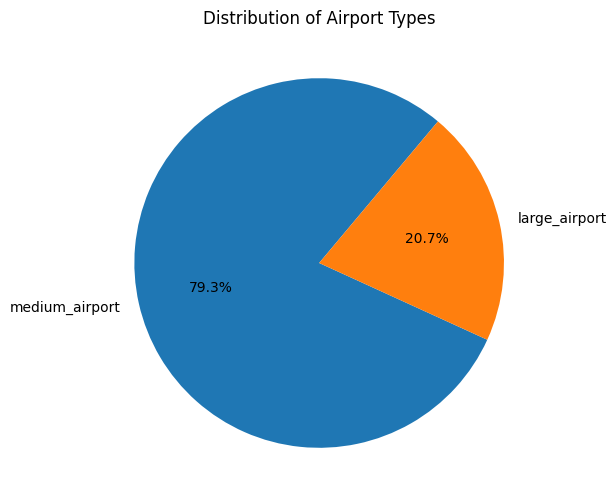

In [33]:
counts = airports_final['TYPE'].value_counts()


plt.figure(figsize=(6, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=50)
plt.title(f'Distribution of Airport Types')
plt.show()

##Tickets Dataset.

In [34]:
tickets

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
0,201912723049,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,736.0,DAB
1,201912723085,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,570.0,COS
2,201912723491,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,564.0,MCO
3,201912723428,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,345.0,LGA
4,201912723509,2019,1,ABI,US,TX,Texas,0.0,MQ,1.0,309.0,MGM
...,...,...,...,...,...,...,...,...,...,...,...,...
1167280,201911284909,2019,1,YAK,US,AK,Alaska,0.0,AS,1.0,244.0,ANC
1167281,201911284959,2019,1,YAK,US,AK,Alaska,1.0,AS,1.0,371.0,JNU
1167282,201911284940,2019,1,YAK,US,AK,Alaska,0.0,AS,1.0,271.0,JNU
1167283,201911284914,2019,1,YAK,US,AK,Alaska,0.0,AS,1.0,603.0,ANC


###Let's consider only roundtrip data.

In [35]:
tickets = tickets[tickets['ROUNDTRIP'] == 1]
tickets

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
0,201912723049,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,736.0,DAB
1,201912723085,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,570.0,COS
2,201912723491,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,564.0,MCO
3,201912723428,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,345.0,LGA
10,201912723337,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,1647.0,JAX
...,...,...,...,...,...,...,...,...,...,...,...,...
1167275,201911284921,2019,1,YAK,US,AK,Alaska,1.0,AS,5.0,11.0,ANC
1167277,201911284924,2019,1,YAK,US,AK,Alaska,1.0,AS,3.0,489.0,ANC
1167279,201911284925,2019,1,YAK,US,AK,Alaska,1.0,AS,3.0,493.0,ANC
1167281,201911284959,2019,1,YAK,US,AK,Alaska,1.0,AS,1.0,371.0,JNU


###Let's remove the columns that we're not using for our analysis.

In [36]:
columns_to_remove_tickets = ['ITIN_ID', 'YEAR', 'QUARTER','ORIGIN_COUNTRY','ORIGIN_STATE_ABR' ]
tickets_new = drop_columns(tickets, columns_to_remove_tickets, inplace=False)
print("DataFrame after dropping specified columns:\n", tickets_new)

DataFrame after dropping specified columns:
         ORIGIN ORIGIN_STATE_NM  ROUNDTRIP REPORTING_CARRIER  PASSENGERS  \
0          ABI           Texas        1.0                MQ         1.0   
1          ABI           Texas        1.0                MQ         1.0   
2          ABI           Texas        1.0                MQ         1.0   
3          ABI           Texas        1.0                MQ         1.0   
10         ABI           Texas        1.0                MQ         1.0   
...        ...             ...        ...               ...         ...   
1167275    YAK          Alaska        1.0                AS         5.0   
1167277    YAK          Alaska        1.0                AS         3.0   
1167279    YAK          Alaska        1.0                AS         3.0   
1167281    YAK          Alaska        1.0                AS         1.0   
1167284    YAK          Alaska        1.0                AS         1.0   

        ITIN_FARE DESTINATION  
0           736.0     

###Removing non-numeric characters from the below columns.

In [37]:
tickets_new['ITIN_FARE'] = tickets_new['ITIN_FARE'].replace('[\$,]', '', regex=True).astype(float)
tickets_new['PASSENGERS'] = tickets_new['PASSENGERS'].astype(float)

In [38]:
tickets_new

,ORIGIN,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
0,ABI,Texas,1.0,MQ,1.0,736.0,DAB
1,ABI,Texas,1.0,MQ,1.0,570.0,COS
2,ABI,Texas,1.0,MQ,1.0,564.0,MCO
3,ABI,Texas,1.0,MQ,1.0,345.0,LGA
10,ABI,Texas,1.0,MQ,1.0,1647.0,JAX
...,...,...,...,...,...,...,...
1167275,YAK,Alaska,1.0,AS,5.0,11.0,ANC
1167277,YAK,Alaska,1.0,AS,3.0,489.0,ANC
1167279,YAK,Alaska,1.0,AS,3.0,493.0,ANC
1167281,YAK,Alaska,1.0,AS,1.0,371.0,JNU


###Cleaning the tickets data

In [39]:
tickets_cleaned = cleaning_data(tickets_new)
print("DataFrame after dropping rows with NaN values:\n", tickets_cleaned)

<ipython-input-4-db207bdc8bf9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_numeric(df[column], errors='coerce')


Dropping null values


<ipython-input-4-db207bdc8bf9>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=[column], inplace=True)
<ipython-input-4-db207bdc8bf9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_numeric(df[column], errors='coerce')


Dropping null values
DataFrame after dropping rows with NaN values:
         ORIGIN ORIGIN_STATE_NM  ROUNDTRIP REPORTING_CARRIER  PASSENGERS  \
0          ABI           Texas        1.0                MQ         1.0   
1          ABI           Texas        1.0                MQ         1.0   
2          ABI           Texas        1.0                MQ         1.0   
3          ABI           Texas        1.0                MQ         1.0   
10         ABI           Texas        1.0                MQ         1.0   
...        ...             ...        ...               ...         ...   
1115053    YUM         Arizona        1.0                YV         1.0   
1115057    YUM         Arizona        1.0                OO         1.0   
1115058    YUM         Arizona        1.0                OO         1.0   
1115066    YUM         Arizona        1.0                OO         1.0   
1115067    YUM         Arizona        1.0                OO         1.0   

         ITIN_FARE DESTINATION

<ipython-input-4-db207bdc8bf9>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=[column], inplace=True)


###Since the maximum capacity of an airplane is 200, let's cap any values more than 200 to 200.

In [40]:
def cap_column(df, column, lower_bound, upper_bound):
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

In [41]:
tickets_updated = tickets_cleaned.copy(deep=True)
cap_column(tickets_updated, 'PASSENGERS', 1, 200)
tickets_updated

,ORIGIN,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
0,ABI,Texas,1.0,MQ,1.0,736.0,DAB
1,ABI,Texas,1.0,MQ,1.0,570.0,COS
2,ABI,Texas,1.0,MQ,1.0,564.0,MCO
3,ABI,Texas,1.0,MQ,1.0,345.0,LGA
10,ABI,Texas,1.0,MQ,1.0,1647.0,JAX
...,...,...,...,...,...,...,...
1115053,YUM,Arizona,1.0,YV,1.0,585.0,FLL
1115057,YUM,Arizona,1.0,OO,1.0,692.0,ALB
1115058,YUM,Arizona,1.0,OO,1.0,600.0,MRY
1115066,YUM,Arizona,1.0,OO,1.0,705.0,ELP


###Let's remove outliers from ITIN_FARE column.

In [42]:

def remove_outliers_iqr(df, column='ITIN_FARE'):

    # Calculating Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return filtered_df


In [43]:
tickets_updated1 = remove_outliers_iqr(tickets_updated, column='ITIN_FARE')
print("DataFrame after removing outliers from 'ITIN_FARE':\n", tickets_updated1)

DataFrame after removing outliers from 'ITIN_FARE':
         ORIGIN ORIGIN_STATE_NM  ROUNDTRIP REPORTING_CARRIER  PASSENGERS  \
0          ABI           Texas        1.0                MQ         1.0   
1          ABI           Texas        1.0                MQ         1.0   
2          ABI           Texas        1.0                MQ         1.0   
3          ABI           Texas        1.0                MQ         1.0   
11         ABI           Texas        1.0                MQ         1.0   
...        ...             ...        ...               ...         ...   
1115053    YUM         Arizona        1.0                YV         1.0   
1115057    YUM         Arizona        1.0                OO         1.0   
1115058    YUM         Arizona        1.0                OO         1.0   
1115066    YUM         Arizona        1.0                OO         1.0   
1115067    YUM         Arizona        1.0                OO         1.0   

         ITIN_FARE DESTINATION  
0            

##Merging the Datasets.

In [44]:
flights_filtered

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-8.0,-6.0,0.0,143.0,1025.0,0.970000
1,2019-03-02,WN,N8686A,3231,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",1.0,5.0,0.0,135.0,930.0,0.550000
2,2019-03-02,WN,N201LV,3383,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",0.0,4.0,0.0,132.0,930.0,0.910000
3,2019-03-02,WN,N413WN,5498,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",11.0,14.0,0.0,136.0,930.0,0.670000
4,2019-03-02,WN,N7832A,6933,14635,RSW,"Fort Myers, FL",11259,DAL,"Dallas, TX",0.0,-17.0,0.0,151.0,1005.0,0.620000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910855,2/21/19,UA,N8606C,DDD,14679,SAN,"San Diego, CA",10397,ATL,"Atlanta, GA",22.0,7.0,0.0,2.0,1892.0,0.584982
1910856,1/8/19,UA,N8525S,YUD,14679,SAN,"San Diego, CA",10423,AUS,"Austin, TX",-2.0,-17.0,0.0,5.0,1164.0,0.394183
1910857,1/18/19,UA,N746SW,ARD,14679,SAN,"San Diego, CA",10693,BNA,"Nashville, TN",28.0,8.0,0.0,6.0,1751.0,0.801383
1910882,3/14/19,AA,N501AA,1406,11298,DFW,"Dallas/Fort Worth, TX",14683,SAT,"San Antonio, TX",43.0,47.0,0.0,52.0,247.0,0.300756


In [45]:
tickets_updated1['TOTAL_FARE'] = tickets_updated1['ITIN_FARE'] * tickets_updated1['PASSENGERS']

grouped_tickets = tickets_updated1.groupby(['ORIGIN', 'DESTINATION']).agg(
    total_revenue=('TOTAL_FARE', 'sum'),
    total_passengers=('PASSENGERS', 'sum')
).reset_index()


grouped_tickets['mean_fare'] = grouped_tickets['total_revenue'] / grouped_tickets['total_passengers']



<ipython-input-45-4e5826d4bd04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickets_updated1['TOTAL_FARE'] = tickets_updated1['ITIN_FARE'] * tickets_updated1['PASSENGERS']


In [46]:
## cancelled is not needed as we have filtered already for non-cancelled flights but still taking count as it could be used to find total number of fligts in the route
flights_grouped = flights_filtered.groupby(['ORIGIN','DESTINATION']).agg({'ORIGIN_CITY_NAME':'first',
                                                                        'DEST_CITY_NAME': 'first',
                                                                        'DEP_DELAY': np.mean,
                                                                        'ARR_DELAY': np.mean,
                                                                        'AIR_TIME': np.mean,
                                                                        'DISTANCE': np.mean,
                                                                        'OCCUPANCY_RATE':np.mean,
                                                                        'CANCELLED':'count'}).reset_index()

<ipython-input-46-ece22ddf2a59>:2: FutureWarning: The provided callable <function mean at 0x781c5721d5a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  flights_grouped = flights_filtered.groupby(['ORIGIN','DESTINATION']).agg({'ORIGIN_CITY_NAME':'first',


In [47]:
flights_grouped

,ORIGIN,DESTINATION,ORIGIN_CITY_NAME,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,AIR_TIME,DISTANCE,OCCUPANCY_RATE,CANCELLED
0,ABE,ATL,"Allentown/Bethlehem/Easton, PA","Atlanta, GA",5.981567,5.460829,107.027650,692.0,0.641567,217
1,ABE,CLT,"Allentown/Bethlehem/Easton, PA","Charlotte, NC",3.812749,4.254980,98.972112,481.0,0.665976,251
2,ABE,DTW,"Allentown/Bethlehem/Easton, PA","Detroit, MI",15.971774,10.689516,83.431452,425.0,0.639073,248
3,ABE,FLL,"Allentown/Bethlehem/Easton, PA","Fort Lauderdale, FL",13.600000,10.850000,145.650000,1041.0,0.580000,20
4,ABE,ORD,"Allentown/Bethlehem/Easton, PA","Chicago, IL",21.729560,15.012579,110.924528,654.0,0.671195,159
...,...,...,...,...,...,...,...,...,...,...
5905,YAK,CDV,"Yakutat, AK","Cordova, AK",-8.612500,-3.875000,38.600000,213.0,0.627125,80
5906,YAK,JNU,"Yakutat, AK","Juneau, AK",-15.107143,-14.261905,34.988095,198.0,0.677619,84
5907,YKM,SEA,"Yakima, WA","Seattle, WA",11.622951,11.495082,29.016393,103.0,0.660393,305
5908,YUM,DFW,"Yuma, AZ","Dallas/Fort Worth, TX",16.000000,15.464286,127.428571,1022.0,0.637143,28


In [48]:
flights_grouped = flights_grouped.rename(columns={'CANCELLED': 'TRIP_COUNT'})

In [49]:
round_trip_flights = pd.merge(
    flights_grouped, flights_grouped,
    left_on=['ORIGIN', 'DESTINATION'], right_on=['DESTINATION', 'ORIGIN'],
    suffixes=('_out', '_return')
).drop_duplicates(subset=['ORIGIN_out', 'DESTINATION_out'])

In [50]:
round_trip_flights

,ORIGIN_out,DESTINATION_out,ORIGIN_CITY_NAME_out,DEST_CITY_NAME_out,DEP_DELAY_out,ARR_DELAY_out,AIR_TIME_out,DISTANCE_out,OCCUPANCY_RATE_out,TRIP_COUNT_out,ORIGIN_return,DESTINATION_return,ORIGIN_CITY_NAME_return,DEST_CITY_NAME_return,DEP_DELAY_return,ARR_DELAY_return,AIR_TIME_return,DISTANCE_return,OCCUPANCY_RATE_return,TRIP_COUNT_return
0,ABE,ATL,"Allentown/Bethlehem/Easton, PA","Atlanta, GA",5.981567,5.460829,107.027650,692.0,0.641567,217,ATL,ABE,"Atlanta, GA","Allentown/Bethlehem/Easton, PA",7.764977,-0.345622,92.373272,692.0,0.667097,217
1,ABE,CLT,"Allentown/Bethlehem/Easton, PA","Charlotte, NC",3.812749,4.254980,98.972112,481.0,0.665976,251,CLT,ABE,"Charlotte, NC","Allentown/Bethlehem/Easton, PA",3.864542,-1.318725,72.131474,481.0,0.656215,251
2,ABE,DTW,"Allentown/Bethlehem/Easton, PA","Detroit, MI",15.971774,10.689516,83.431452,425.0,0.639073,248,DTW,ABE,"Detroit, MI","Allentown/Bethlehem/Easton, PA",11.423387,1.274194,60.012097,425.0,0.650766,248
3,ABE,FLL,"Allentown/Bethlehem/Easton, PA","Fort Lauderdale, FL",13.600000,10.850000,145.650000,1041.0,0.580000,20,FLL,ABE,"Fort Lauderdale, FL","Allentown/Bethlehem/Easton, PA",-2.800000,-2.350000,149.200000,1041.0,0.630500,20
4,ABE,ORD,"Allentown/Bethlehem/Easton, PA","Chicago, IL",21.729560,15.012579,110.924528,654.0,0.671195,159,ORD,ABE,"Chicago, IL","Allentown/Bethlehem/Easton, PA",36.251572,32.320755,82.138365,654.0,0.627673,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5886,YAK,CDV,"Yakutat, AK","Cordova, AK",-8.612500,-3.875000,38.600000,213.0,0.627125,80,CDV,YAK,"Cordova, AK","Yakutat, AK",-11.908046,-7.459770,37.068966,213.0,0.659655,87
5887,YAK,JNU,"Yakutat, AK","Juneau, AK",-15.107143,-14.261905,34.988095,198.0,0.677619,84,JNU,YAK,"Juneau, AK","Yakutat, AK",2.691358,3.358025,37.740741,198.0,0.629259,81
5888,YKM,SEA,"Yakima, WA","Seattle, WA",11.622951,11.495082,29.016393,103.0,0.660393,305,SEA,YKM,"Seattle, WA","Yakima, WA",5.767213,8.357377,28.400000,103.0,0.637639,305
5889,YUM,DFW,"Yuma, AZ","Dallas/Fort Worth, TX",16.000000,15.464286,127.428571,1022.0,0.637143,28,DFW,YUM,"Dallas/Fort Worth, TX","Yuma, AZ",46.689655,49.137931,150.482759,1022.0,0.643448,29


In [51]:
def add_min_column(df, col1, col2, new_col):

    df[new_col] = df[[col1, col2]].min(axis=1)

    return df

In [52]:
round_trip_flights = add_min_column(round_trip_flights, 'TRIP_COUNT_out', 'TRIP_COUNT_return', 'ROUND_TRIP_COUNT')
round_trip_flights

,ORIGIN_out,DESTINATION_out,ORIGIN_CITY_NAME_out,DEST_CITY_NAME_out,DEP_DELAY_out,ARR_DELAY_out,AIR_TIME_out,DISTANCE_out,OCCUPANCY_RATE_out,TRIP_COUNT_out,...,DESTINATION_return,ORIGIN_CITY_NAME_return,DEST_CITY_NAME_return,DEP_DELAY_return,ARR_DELAY_return,AIR_TIME_return,DISTANCE_return,OCCUPANCY_RATE_return,TRIP_COUNT_return,ROUND_TRIP_COUNT
0,ABE,ATL,"Allentown/Bethlehem/Easton, PA","Atlanta, GA",5.981567,5.460829,107.027650,692.0,0.641567,217,...,ABE,"Atlanta, GA","Allentown/Bethlehem/Easton, PA",7.764977,-0.345622,92.373272,692.0,0.667097,217,217
1,ABE,CLT,"Allentown/Bethlehem/Easton, PA","Charlotte, NC",3.812749,4.254980,98.972112,481.0,0.665976,251,...,ABE,"Charlotte, NC","Allentown/Bethlehem/Easton, PA",3.864542,-1.318725,72.131474,481.0,0.656215,251,251
2,ABE,DTW,"Allentown/Bethlehem/Easton, PA","Detroit, MI",15.971774,10.689516,83.431452,425.0,0.639073,248,...,ABE,"Detroit, MI","Allentown/Bethlehem/Easton, PA",11.423387,1.274194,60.012097,425.0,0.650766,248,248
3,ABE,FLL,"Allentown/Bethlehem/Easton, PA","Fort Lauderdale, FL",13.600000,10.850000,145.650000,1041.0,0.580000,20,...,ABE,"Fort Lauderdale, FL","Allentown/Bethlehem/Easton, PA",-2.800000,-2.350000,149.200000,1041.0,0.630500,20,20
4,ABE,ORD,"Allentown/Bethlehem/Easton, PA","Chicago, IL",21.729560,15.012579,110.924528,654.0,0.671195,159,...,ABE,"Chicago, IL","Allentown/Bethlehem/Easton, PA",36.251572,32.320755,82.138365,654.0,0.627673,159,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5886,YAK,CDV,"Yakutat, AK","Cordova, AK",-8.612500,-3.875000,38.600000,213.0,0.627125,80,...,YAK,"Cordova, AK","Yakutat, AK",-11.908046,-7.459770,37.068966,213.0,0.659655,87,80
5887,YAK,JNU,"Yakutat, AK","Juneau, AK",-15.107143,-14.261905,34.988095,198.0,0.677619,84,...,YAK,"Juneau, AK","Yakutat, AK",2.691358,3.358025,37.740741,198.0,0.629259,81,81
5888,YKM,SEA,"Yakima, WA","Seattle, WA",11.622951,11.495082,29.016393,103.0,0.660393,305,...,YKM,"Seattle, WA","Yakima, WA",5.767213,8.357377,28.400000,103.0,0.637639,305,305
5889,YUM,DFW,"Yuma, AZ","Dallas/Fort Worth, TX",16.000000,15.464286,127.428571,1022.0,0.637143,28,...,YUM,"Dallas/Fort Worth, TX","Yuma, AZ",46.689655,49.137931,150.482759,1022.0,0.643448,29,28


In [53]:
# Merging tickets with flights on origin and destination
final = grouped_tickets.merge(round_trip_flights,
    left_on=['ORIGIN', 'DESTINATION'], right_on=['ORIGIN_out', 'DESTINATION_out']).drop_duplicates(subset=['ORIGIN_out', 'DESTINATION_out'])

In [54]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5776 entries, 0 to 5775
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ORIGIN                   5776 non-null   object 
 1   DESTINATION              5776 non-null   object 
 2   total_revenue            5776 non-null   float64
 3   total_passengers         5776 non-null   float64
 4   mean_fare                5776 non-null   float64
 5   ORIGIN_out               5776 non-null   object 
 6   DESTINATION_out          5776 non-null   object 
 7   ORIGIN_CITY_NAME_out     5776 non-null   object 
 8   DEST_CITY_NAME_out       5776 non-null   object 
 9   DEP_DELAY_out            5776 non-null   float64
 10  ARR_DELAY_out            5776 non-null   float64
 11  AIR_TIME_out             5776 non-null   float64
 12  DISTANCE_out             5776 non-null   float64
 13  OCCUPANCY_RATE_out       5776 non-null   float64
 14  TRIP_COUNT_out          

In [55]:
# Merging final dataset with airport_codes for origin airport details
final = final.merge(airports_final, left_on='ORIGIN', right_on='IATA_CODE', suffixes=('', '_origin')).drop_duplicates(subset=['ORIGIN_out', 'DESTINATION_out'])

In [56]:
final

,ORIGIN,DESTINATION,total_revenue,total_passengers,mean_fare,ORIGIN_out,DESTINATION_out,ORIGIN_CITY_NAME_out,DEST_CITY_NAME_out,DEP_DELAY_out,...,DEP_DELAY_return,ARR_DELAY_return,AIR_TIME_return,DISTANCE_return,OCCUPANCY_RATE_return,TRIP_COUNT_return,ROUND_TRIP_COUNT,TYPE,NAME,IATA_CODE
0,ABE,ATL,27624.0,56.0,493.285714,ABE,ATL,"Allentown/Bethlehem/Easton, PA","Atlanta, GA",5.981567,...,7.764977,-0.345622,92.373272,692.0,0.667097,217,217,medium_airport,Lehigh Valley International Airport,ABE
1,ABE,CLT,14987.0,29.0,516.793103,ABE,CLT,"Allentown/Bethlehem/Easton, PA","Charlotte, NC",3.812749,...,3.864542,-1.318725,72.131474,481.0,0.656215,251,251,medium_airport,Lehigh Valley International Airport,ABE
2,ABE,DTW,13930.0,42.0,331.666667,ABE,DTW,"Allentown/Bethlehem/Easton, PA","Detroit, MI",15.971774,...,11.423387,1.274194,60.012097,425.0,0.650766,248,248,medium_airport,Lehigh Valley International Airport,ABE
3,ABE,FLL,17951.0,85.0,211.188235,ABE,FLL,"Allentown/Bethlehem/Easton, PA","Fort Lauderdale, FL",13.600000,...,-2.800000,-2.350000,149.200000,1041.0,0.630500,20,20,medium_airport,Lehigh Valley International Airport,ABE
4,ABE,ORD,11859.0,20.0,592.950000,ABE,ORD,"Allentown/Bethlehem/Easton, PA","Chicago, IL",21.729560,...,36.251572,32.320755,82.138365,654.0,0.627673,159,159,medium_airport,Lehigh Valley International Airport,ABE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,YAK,CDV,11.0,1.0,11.000000,YAK,CDV,"Yakutat, AK","Cordova, AK",-8.612500,...,-11.908046,-7.459770,37.068966,213.0,0.659655,87,80,medium_airport,Yakutat Airport,YAK
5630,YAK,JNU,3994.0,15.0,266.266667,YAK,JNU,"Yakutat, AK","Juneau, AK",-15.107143,...,2.691358,3.358025,37.740741,198.0,0.629259,81,81,medium_airport,Yakutat Airport,YAK
5631,YKM,SEA,11000.0,43.0,255.813953,YKM,SEA,"Yakima, WA","Seattle, WA",11.622951,...,5.767213,8.357377,28.400000,103.0,0.637639,305,305,medium_airport,Yakima Air Terminal McAllister Field,YKM
5632,YUM,DFW,1837.0,4.0,459.250000,YUM,DFW,"Yuma, AZ","Dallas/Fort Worth, TX",16.000000,...,46.689655,49.137931,150.482759,1022.0,0.643448,29,28,medium_airport,Yuma MCAS/Yuma International Airport,YUM


In [57]:
# Merging with airport_codes again for destination airport details
final = final.merge(airports_final, left_on='DESTINATION', right_on='IATA_CODE', suffixes=('_origin', '_destination')).drop_duplicates(subset=['ORIGIN_out', 'DESTINATION_out'])

In [58]:
# Dropping redundant columns
final.drop(columns=['IATA_CODE_origin', 'IATA_CODE_destination'], inplace=True)

###Let's have a look at the final data.

In [59]:
final

,ORIGIN,DESTINATION,total_revenue,total_passengers,mean_fare,ORIGIN_out,DESTINATION_out,ORIGIN_CITY_NAME_out,DEST_CITY_NAME_out,DEP_DELAY_out,...,ARR_DELAY_return,AIR_TIME_return,DISTANCE_return,OCCUPANCY_RATE_return,TRIP_COUNT_return,ROUND_TRIP_COUNT,TYPE_origin,NAME_origin,TYPE_destination,NAME_destination
0,ABE,ATL,27624.0,56.0,493.285714,ABE,ATL,"Allentown/Bethlehem/Easton, PA","Atlanta, GA",5.981567,...,-0.345622,92.373272,692.0,0.667097,217,217,medium_airport,Lehigh Valley International Airport,large_airport,Hartsfield Jackson Atlanta International Airport
1,ABE,CLT,14987.0,29.0,516.793103,ABE,CLT,"Allentown/Bethlehem/Easton, PA","Charlotte, NC",3.812749,...,-1.318725,72.131474,481.0,0.656215,251,251,medium_airport,Lehigh Valley International Airport,large_airport,Charlotte Douglas International Airport
2,ABE,DTW,13930.0,42.0,331.666667,ABE,DTW,"Allentown/Bethlehem/Easton, PA","Detroit, MI",15.971774,...,1.274194,60.012097,425.0,0.650766,248,248,medium_airport,Lehigh Valley International Airport,large_airport,Detroit Metropolitan Wayne County Airport
3,ABE,FLL,17951.0,85.0,211.188235,ABE,FLL,"Allentown/Bethlehem/Easton, PA","Fort Lauderdale, FL",13.600000,...,-2.350000,149.200000,1041.0,0.630500,20,20,medium_airport,Lehigh Valley International Airport,large_airport,Fort Lauderdale Hollywood International Airport
4,ABE,ORD,11859.0,20.0,592.950000,ABE,ORD,"Allentown/Bethlehem/Easton, PA","Chicago, IL",21.729560,...,32.320755,82.138365,654.0,0.627673,159,159,medium_airport,Lehigh Valley International Airport,large_airport,Chicago O'Hare International Airport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5500,YAK,CDV,11.0,1.0,11.000000,YAK,CDV,"Yakutat, AK","Cordova, AK",-8.612500,...,-7.459770,37.068966,213.0,0.659655,87,80,medium_airport,Yakutat Airport,medium_airport,Merle K (Mudhole) Smith Airport
5501,YAK,JNU,3994.0,15.0,266.266667,YAK,JNU,"Yakutat, AK","Juneau, AK",-15.107143,...,3.358025,37.740741,198.0,0.629259,81,81,medium_airport,Yakutat Airport,medium_airport,Juneau International Airport
5502,YKM,SEA,11000.0,43.0,255.813953,YKM,SEA,"Yakima, WA","Seattle, WA",11.622951,...,8.357377,28.400000,103.0,0.637639,305,305,medium_airport,Yakima Air Terminal McAllister Field,large_airport,Seattle Tacoma International Airport
5503,YUM,DFW,1837.0,4.0,459.250000,YUM,DFW,"Yuma, AZ","Dallas/Fort Worth, TX",16.000000,...,49.137931,150.482759,1022.0,0.643448,29,28,medium_airport,Yuma MCAS/Yuma International Airport,large_airport,Dallas Fort Worth International Airport


In [60]:
# Creating a route column for clarity
final['route'] = final['ORIGIN_CITY_NAME_out'] + ' TO ' + final['DEST_CITY_NAME_out']

In [61]:
final

,ORIGIN,DESTINATION,total_revenue,total_passengers,mean_fare,ORIGIN_out,DESTINATION_out,ORIGIN_CITY_NAME_out,DEST_CITY_NAME_out,DEP_DELAY_out,...,AIR_TIME_return,DISTANCE_return,OCCUPANCY_RATE_return,TRIP_COUNT_return,ROUND_TRIP_COUNT,TYPE_origin,NAME_origin,TYPE_destination,NAME_destination,route
0,ABE,ATL,27624.0,56.0,493.285714,ABE,ATL,"Allentown/Bethlehem/Easton, PA","Atlanta, GA",5.981567,...,92.373272,692.0,0.667097,217,217,medium_airport,Lehigh Valley International Airport,large_airport,Hartsfield Jackson Atlanta International Airport,"Allentown/Bethlehem/Easton, PA TO Atlanta, GA"
1,ABE,CLT,14987.0,29.0,516.793103,ABE,CLT,"Allentown/Bethlehem/Easton, PA","Charlotte, NC",3.812749,...,72.131474,481.0,0.656215,251,251,medium_airport,Lehigh Valley International Airport,large_airport,Charlotte Douglas International Airport,"Allentown/Bethlehem/Easton, PA TO Charlotte, NC"
2,ABE,DTW,13930.0,42.0,331.666667,ABE,DTW,"Allentown/Bethlehem/Easton, PA","Detroit, MI",15.971774,...,60.012097,425.0,0.650766,248,248,medium_airport,Lehigh Valley International Airport,large_airport,Detroit Metropolitan Wayne County Airport,"Allentown/Bethlehem/Easton, PA TO Detroit, MI"
3,ABE,FLL,17951.0,85.0,211.188235,ABE,FLL,"Allentown/Bethlehem/Easton, PA","Fort Lauderdale, FL",13.600000,...,149.200000,1041.0,0.630500,20,20,medium_airport,Lehigh Valley International Airport,large_airport,Fort Lauderdale Hollywood International Airport,"Allentown/Bethlehem/Easton, PA TO Fort Lauderd..."
4,ABE,ORD,11859.0,20.0,592.950000,ABE,ORD,"Allentown/Bethlehem/Easton, PA","Chicago, IL",21.729560,...,82.138365,654.0,0.627673,159,159,medium_airport,Lehigh Valley International Airport,large_airport,Chicago O'Hare International Airport,"Allentown/Bethlehem/Easton, PA TO Chicago, IL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5500,YAK,CDV,11.0,1.0,11.000000,YAK,CDV,"Yakutat, AK","Cordova, AK",-8.612500,...,37.068966,213.0,0.659655,87,80,medium_airport,Yakutat Airport,medium_airport,Merle K (Mudhole) Smith Airport,"Yakutat, AK TO Cordova, AK"
5501,YAK,JNU,3994.0,15.0,266.266667,YAK,JNU,"Yakutat, AK","Juneau, AK",-15.107143,...,37.740741,198.0,0.629259,81,81,medium_airport,Yakutat Airport,medium_airport,Juneau International Airport,"Yakutat, AK TO Juneau, AK"
5502,YKM,SEA,11000.0,43.0,255.813953,YKM,SEA,"Yakima, WA","Seattle, WA",11.622951,...,28.400000,103.0,0.637639,305,305,medium_airport,Yakima Air Terminal McAllister Field,large_airport,Seattle Tacoma International Airport,"Yakima, WA TO Seattle, WA"
5503,YUM,DFW,1837.0,4.0,459.250000,YUM,DFW,"Yuma, AZ","Dallas/Fort Worth, TX",16.000000,...,150.482759,1022.0,0.643448,29,28,medium_airport,Yuma MCAS/Yuma International Airport,large_airport,Dallas Fort Worth International Airport,"Yuma, AZ TO Dallas/Fort Worth, TX"


##QUESTION 1 - The 10 busiest round trip routes in terms of number of round trip flights in the quarter.

<ipython-input-62-566216a4f21e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='route', y='ROUND_TRIP_COUNT', data=top_routes, palette='deep')
<ipython-input-62-566216a4f21e>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)


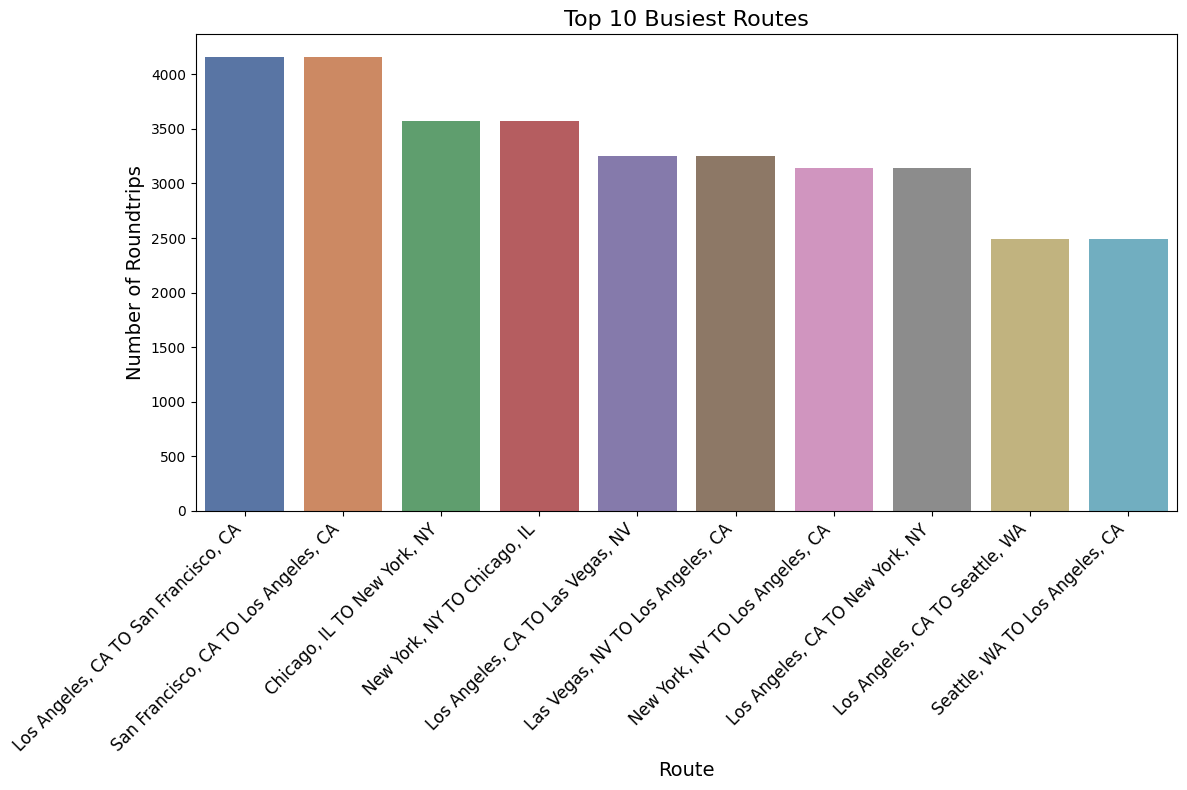

In [62]:
top_routes = final.sort_values(by='ROUND_TRIP_COUNT', ascending=False).head(10)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='route', y='ROUND_TRIP_COUNT', data=top_routes, palette='deep')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax.set_xlabel('Route', fontsize=14)
ax.set_ylabel('Number of Roundtrips', fontsize=14)
ax.set_title('Top 10 Busiest Routes', fontsize=16)
plt.tight_layout()
plt.show()

##QUESTION 2 - The 10 most profitable round trip routes (without considering the upfront airplane cost) in the quarter. Along with the profit, show total revenue, total cost, summary values of other key components and total round trip flights in the quarter for the top 10 most profitable routes.

###Creating a function to get the average of the main metrics that we're using for analysis.

In [63]:
def average_columns(df, column_pairs):

    for new_col, cols in column_pairs.items():
        df[new_col] = df[cols].mean(axis=1)

    return df

In [64]:
column_pairs = {
    'DEP_DELAY': ['DEP_DELAY_out', 'DEP_DELAY_return'],
    'ARR_DELAY': ['ARR_DELAY_out', 'ARR_DELAY_return'],
    'DISTANCE': ['DISTANCE_out', 'DISTANCE_return'],
    'OCCUPANCY_RATE': ['OCCUPANCY_RATE_out', 'OCCUPANCY_RATE_return']
}

final = average_columns(final, column_pairs)

In [65]:
final_data =final[['route','mean_fare','DEP_DELAY','ARR_DELAY','DISTANCE','OCCUPANCY_RATE','ROUND_TRIP_COUNT','TYPE_origin','TYPE_destination']]

In [66]:
final_data

,route,mean_fare,DEP_DELAY,ARR_DELAY,DISTANCE,OCCUPANCY_RATE,ROUND_TRIP_COUNT,TYPE_origin,TYPE_destination
0,"Allentown/Bethlehem/Easton, PA TO Atlanta, GA",493.285714,6.873272,2.557604,692.0,0.654332,217,medium_airport,large_airport
1,"Allentown/Bethlehem/Easton, PA TO Charlotte, NC",516.793103,3.838645,1.468127,481.0,0.661096,251,medium_airport,large_airport
2,"Allentown/Bethlehem/Easton, PA TO Detroit, MI",331.666667,13.697581,5.981855,425.0,0.644919,248,medium_airport,large_airport
3,"Allentown/Bethlehem/Easton, PA TO Fort Lauderd...",211.188235,5.400000,4.250000,1041.0,0.605250,20,medium_airport,large_airport
4,"Allentown/Bethlehem/Easton, PA TO Chicago, IL",592.950000,28.990566,23.666667,654.0,0.649434,159,medium_airport,large_airport
...,...,...,...,...,...,...,...,...,...
5500,"Yakutat, AK TO Cordova, AK",11.000000,-10.260273,-5.667385,213.0,0.643390,80,medium_airport,medium_airport
5501,"Yakutat, AK TO Juneau, AK",266.266667,-6.207892,-5.451940,198.0,0.653439,81,medium_airport,medium_airport
5502,"Yakima, WA TO Seattle, WA",255.813953,8.695082,9.926230,103.0,0.649016,305,medium_airport,large_airport
5503,"Yuma, AZ TO Dallas/Fort Worth, TX",459.250000,31.344828,32.301108,1022.0,0.640296,28,medium_airport,large_airport


###Below are variables for cost and maintennace as given.

In [67]:
Fuel_Oil = 8
Deprec_Insur = 1.18
Cost_per_mile = Fuel_Oil + Deprec_Insur
Airport_Med = 5000 * 2
Airport_Lar = 10000 * 2
Delay_per_min = 75
Baggage = 35 * 2
Baggage_prob = 0.5
Baggage_cost = Baggage * Baggage_prob
Passenegers = 200

### Added below columns to the final data as part of our analysis.

AIRPORT_COST: cost of operating at both the origin and destination airports based on their size (medium or large).

ARR_DELAY_COST: additional cost due to arrival delays beyond 15 minutes.

DEP_DELAY_COST: additional cost due to departure delays beyond 15 minutes.

ESSENTIALS_COST: The basic operational cost based on the distance of the route.

TOTAL_COST: overall cost to operate the route, combining delay costs, airport costs, and basic operational costs.

TOTAL_FARE: total revenue generated from passenger fares, factoring in the occupancy rate.

BAGGAGE_COST: revenue or cost generated from baggage charges, based on the number of passengers and occupancy rate.

TOTAL_REVENUE: total revenue generated from the route, combining both the total fare and baggage charges.

In [68]:
final_data ['AIRPORT_COST']  = 1

final_data['ARR_DELAY_COST']=np.where(final_data['ARR_DELAY'] > 15, ((final_data['ARR_DELAY'] - 15 )*75), 0)

final_data['DEP_DELAY_COST']=np.where(final_data['DEP_DELAY'] > 15, ((final_data['DEP_DELAY'] - 15) *75), 0)

final_data['AIRPORT_COST'] = (np.where((final_data['TYPE_origin']=='medium_airport'),final_data['AIRPORT_COST']* Airport_Med, final_data['AIRPORT_COST'] * Airport_Lar)) + (np.where((final_data['TYPE_destination']=='medium_airport'),final_data['AIRPORT_COST']* Airport_Med, final_data['AIRPORT_COST'] * Airport_Lar))

final_data['ESSENTIALS_COST']=final_data['DISTANCE'] * Cost_per_mile

final_data['TOTAL_COST']=final_data['ARR_DELAY_COST']+final_data['DEP_DELAY_COST']+final_data['AIRPORT_COST']+final_data['ESSENTIALS_COST']

final_data['TOTAL_FARE']= Passenegers * final_data['mean_fare'] * final_data['OCCUPANCY_RATE']

final_data['BAGGAGE_COST']=Passenegers * final_data['OCCUPANCY_RATE'] * Baggage_cost

final_data['TOTAL_REVENUE']=final_data.loc[:,['TOTAL_FARE','BAGGAGE_COST']].sum(axis=1)

<ipython-input-68-44ef2cb73ac3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data ['AIRPORT_COST']  = 1
<ipython-input-68-44ef2cb73ac3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['ARR_DELAY_COST']=np.where(final_data['ARR_DELAY'] > 15, ((final_data['ARR_DELAY'] - 15 )*75), 0)
<ipython-input-68-44ef2cb73ac3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [69]:
final_data

,route,mean_fare,DEP_DELAY,ARR_DELAY,DISTANCE,OCCUPANCY_RATE,ROUND_TRIP_COUNT,TYPE_origin,TYPE_destination,AIRPORT_COST,ARR_DELAY_COST,DEP_DELAY_COST,ESSENTIALS_COST,TOTAL_COST,TOTAL_FARE,BAGGAGE_COST,TOTAL_REVENUE
0,"Allentown/Bethlehem/Easton, PA TO Atlanta, GA",493.285714,6.873272,2.557604,692.0,0.654332,217,medium_airport,large_airport,30000,0.000000,0.000000,6352.56,36352.560000,64554.505596,4580.322581,69134.828176
1,"Allentown/Bethlehem/Easton, PA TO Charlotte, NC",516.793103,3.838645,1.468127,481.0,0.661096,251,medium_airport,large_airport,30000,0.000000,0.000000,4415.58,34415.580000,68329.931172,4627.669323,72957.600495
2,"Allentown/Bethlehem/Easton, PA TO Detroit, MI",331.666667,13.697581,5.981855,425.0,0.644919,248,medium_airport,large_airport,30000,0.000000,0.000000,3901.50,33901.500000,42779.650538,4514.435484,47294.086022
3,"Allentown/Bethlehem/Easton, PA TO Fort Lauderd...",211.188235,5.400000,4.250000,1041.0,0.605250,20,medium_airport,large_airport,30000,0.000000,0.000000,9556.38,39556.380000,25564.335882,4236.750000,29801.085882
4,"Allentown/Bethlehem/Easton, PA TO Chicago, IL",592.950000,28.990566,23.666667,654.0,0.649434,159,medium_airport,large_airport,30000,650.000000,1049.292453,6003.72,37703.012453,77016.373585,4546.037736,81562.411321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5500,"Yakutat, AK TO Cordova, AK",11.000000,-10.260273,-5.667385,213.0,0.643390,80,medium_airport,medium_airport,20000,0.000000,0.000000,1955.34,21955.340000,1415.458190,4503.730603,5919.188793
5501,"Yakutat, AK TO Juneau, AK",266.266667,-6.207892,-5.451940,198.0,0.653439,81,medium_airport,medium_airport,20000,0.000000,0.000000,1817.64,21817.640000,34797.813051,4574.074074,39371.887125
5502,"Yakima, WA TO Seattle, WA",255.813953,8.695082,9.926230,103.0,0.649016,305,medium_airport,large_airport,30000,0.000000,0.000000,945.54,30945.540000,33205.489897,4543.114754,37748.604651
5503,"Yuma, AZ TO Dallas/Fort Worth, TX",459.250000,31.344828,32.301108,1022.0,0.640296,28,medium_airport,large_airport,30000,1297.583128,1225.862069,9381.96,41905.405197,58811.147783,4482.068966,63293.216749


##The 10 most profitable round trip routes in the quarter.

### Added below columns for the final analysis:

*   profit - Profit for one roundtrip for each route.
*   TOTAL_PROFIT - Total profit of all roundtrips for each route.




<ipython-input-70-b1fe8f2baaa7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['profit']=(final_data['TOTAL_REVENUE']-final_data['TOTAL_COST'])
<ipython-input-70-b1fe8f2baaa7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['TOTAL_PROFIT'] = final_data['profit'] * final_data['ROUND_TRIP_COUNT']
<ipython-input-70-b1fe8f2baaa7>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=Fa

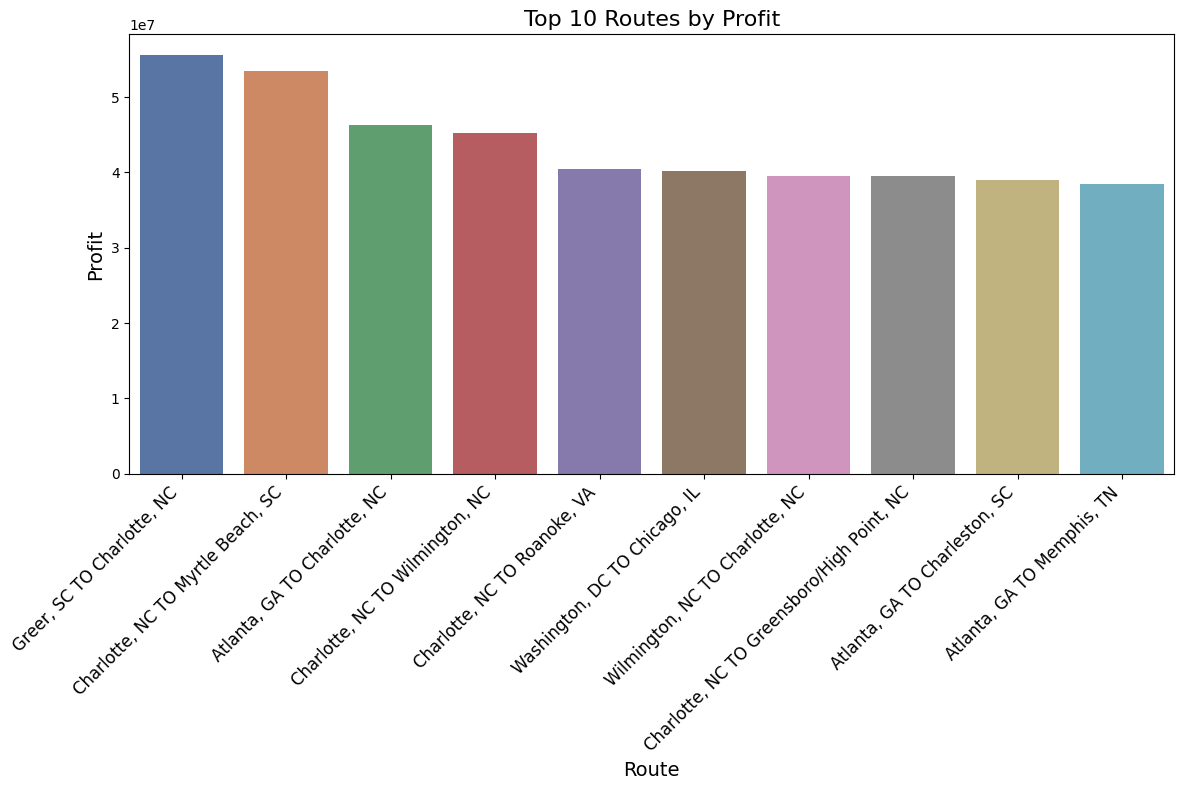

In [70]:
final_data['profit']=(final_data['TOTAL_REVENUE']-final_data['TOTAL_COST'])
final_data['TOTAL_PROFIT'] = final_data['profit'] * final_data['ROUND_TRIP_COUNT']

top_routes_profit = final_data.sort_values(by='TOTAL_PROFIT', ascending=False).head(10)


plt.figure(figsize=(12, 8))
ax = sns.barplot(x='route', y='TOTAL_PROFIT', data=top_routes_profit, palette='deep')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax.set_xlabel('Route', fontsize=14)
ax.set_ylabel('Profit', fontsize=14)
ax.set_title('Top 10 Routes by Profit', fontsize=16)
plt.tight_layout()
plt.show()

In [71]:
key_components = top_routes_profit[['route','profit', 'TOTAL_REVENUE', 'TOTAL_COST', 'ROUND_TRIP_COUNT', 'DEP_DELAY',	'ARR_DELAY' , 'DISTANCE', 'OCCUPANCY_RATE', 'TOTAL_PROFIT']]
key_components

,route,profit,TOTAL_REVENUE,TOTAL_COST,ROUND_TRIP_COUNT,DEP_DELAY,ARR_DELAY,DISTANCE,OCCUPANCY_RATE,TOTAL_PROFIT
2086,"Greer, SC TO Charlotte, NC",71948.014396,112636.514396,40688.50,772,7.051417,-0.067140,75.0,0.649576,5.554387e+07
941,"Charlotte, NC TO Myrtle Beach, SC",78919.946056,110361.206056,31441.26,677,3.485229,-2.269572,157.0,0.646521,5.342880e+07
136,"Atlanta, GA TO Charlotte, NC",30154.529910,72229.209910,42074.68,1534,5.772151,-0.301434,226.0,0.648667,4.625705e+07
915,"Charlotte, NC TO Wilmington, NC",61858.099847,93556.399847,31698.30,732,4.509605,-0.415476,185.0,0.655922,4.528013e+07
960,"Charlotte, NC TO Roanoke, VA",68448.999672,109871.899672,41422.90,591,6.082235,-1.251858,155.0,0.663478,4.045336e+07
1241,"Washington, DC TO Chicago, IL",21802.508231,67420.668231,45618.16,1843,10.264349,6.458829,612.0,0.647833,4.018202e+07
2432,"Wilmington, NC TO Charlotte, NC",54014.361019,85712.661019,31698.30,732,4.509605,-0.415476,185.0,0.655922,3.953851e+07
906,"Charlotte, NC TO Greensboro/High Point, NC",53117.899220,93879.839220,40761.94,743,5.479778,-1.207404,83.0,0.651039,3.946660e+07
133,"Atlanta, GA TO Charleston, SC",47317.621323,89695.241323,42377.62,823,1.000781,-6.214315,259.0,0.644876,3.894240e+07
196,"Atlanta, GA TO Memphis, TN",45891.741392,88939.501392,43047.76,839,3.456467,-2.667475,332.0,0.646428,3.850317e+07


##QUESTION 3 - The 5 round trip routes that you recommend to invest in based on any factors that you choose.


To identify the top 5 routes based on profitability, punctuality, and how busy a route is,  I decided to create a composite score instead of just sorting by profit alone. This allowed me to evaluate each route in a much more balanced way.

###Step 1: Normalizing Each Metric
Since the metrics I wanted to consider (like profit, round trip count, and delays) have different scales, I first needed to bring them onto a common ground. Without this, the metrics with larger values like profit could overshadow others. So, I applied Min-Max normalization, which scales each metric to a range between 0 and 1, making it easier to compare them.

For profit and trip count, higher values are better, so I normalized them directly.
For departure and arrival delays, lower values are better since I want punctuality to positively impact the score. For these, I inverted the normalized values (1 - normalized delay) so that routes with lower delays score higher in the final calculation.

###Step 2: Selecting Key Metrics and Setting Priorities
The metrics I chose each serve a specific purpose in evaluating route quality:

####Profit (TOTAL_PROFIT):
This metric is fundamental as it represents the revenue generated by each route. Higher profits are always desirable, so I wanted it to play a significant role in the ranking.
####Round Trip Count (ROUND_TRIP_COUNT):
Routes with more trips indicate steady demand, suggesting they’re valuable to the network. However, I didn’t want this metric to overshadow others, so I assigned it a moderate weight.
####Departure Delay (DEP_DELAY) and Arrival Delay (ARR_DELAY):
On-time performance is crucial both for operational efficiency and for keeping customers happy. Therefore, I prioritized these metrics by assigning them higher weights in the final composite score.


In [72]:
def find_top_routes(df, profit_weight=0.3, trip_weight=0.2, dep_delay_weight=0.25, arr_delay_weight=0.25):

    df['profit_norm'] = (df['TOTAL_PROFIT'] - df['TOTAL_PROFIT'].min()) / (df['TOTAL_PROFIT'].max() - df['TOTAL_PROFIT'].min())
    df['trip_norm'] = (df['ROUND_TRIP_COUNT'] - df['ROUND_TRIP_COUNT'].min()) / (df['ROUND_TRIP_COUNT'].max() - df['ROUND_TRIP_COUNT'].min())
    df['dep_delay_norm'] = 1 - ((df['DEP_DELAY'] - df['DEP_DELAY'].min()) / (df['DEP_DELAY'].max() - df['DEP_DELAY'].min()))
    df['arr_delay_norm'] = 1 - ((df['ARR_DELAY'] - df['ARR_DELAY'].min()) / (df['ARR_DELAY'].max() - df['ARR_DELAY'].min()))

    # Calculating composite score
    df['composite_score'] = (
        df['profit_norm'] * profit_weight +
        df['trip_norm'] * trip_weight +
        df['dep_delay_norm'] * dep_delay_weight +
        df['arr_delay_norm'] * arr_delay_weight
    )

    # Sort by composite score in descending order to get top routes
    top_routes = df.sort_values(by='composite_score', ascending=False).head(5)

    # Cleaned up by dropping the temporary columns
    top_routes = top_routes.drop(columns=['profit_norm', 'trip_norm', 'dep_delay_norm', 'arr_delay_norm', 'composite_score'])

    return top_routes

In [73]:
ordered_final = find_top_routes(final_data)
ordered_final.head()

<ipython-input-72-74c97b2f6b27>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['profit_norm'] = (df['TOTAL_PROFIT'] - df['TOTAL_PROFIT'].min()) / (df['TOTAL_PROFIT'].max() - df['TOTAL_PROFIT'].min())
<ipython-input-72-74c97b2f6b27>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trip_norm'] = (df['ROUND_TRIP_COUNT'] - df['ROUND_TRIP_COUNT'].min()) / (df['ROUND_TRIP_COUNT'].max() - df['ROUND_TRIP_COUNT'].min())
<ipython-input-72-74c97b2f6b27>:5: SettingWithCopyWarning: 
A value is trying to be set 

,route,mean_fare,DEP_DELAY,ARR_DELAY,DISTANCE,OCCUPANCY_RATE,ROUND_TRIP_COUNT,TYPE_origin,TYPE_destination,AIRPORT_COST,ARR_DELAY_COST,DEP_DELAY_COST,ESSENTIALS_COST,TOTAL_COST,TOTAL_FARE,BAGGAGE_COST,TOTAL_REVENUE,profit,TOTAL_PROFIT
136,"Atlanta, GA TO Charlotte, NC",521.751269,5.772151,-0.301434,226.0,0.648667,1534,large_airport,large_airport,40000,0.0,0.0,2074.68,42074.68,67688.542493,4540.667417,72229.209910,30154.529910,4.625705e+07
1241,"Washington, DC TO Chicago, IL",485.355408,10.264349,6.458829,612.0,0.647833,1843,large_airport,large_airport,40000,0.0,0.0,5618.16,45618.16,62885.838094,4534.830137,67420.668231,21802.508231,4.018202e+07
2086,"Greer, SC TO Charlotte, NC",832.000000,7.051417,-0.067140,75.0,0.649576,772,large_airport,large_airport,40000,0.0,0.0,688.50,40688.50,108089.480943,4547.033453,112636.514396,71948.014396,5.554387e+07
941,"Charlotte, NC TO Myrtle Beach, SC",818.500000,3.485229,-2.269572,157.0,0.646521,677,large_airport,medium_airport,30000,0.0,0.0,1441.26,31441.26,105835.556130,4525.649926,110361.206056,78919.946056,5.342880e+07
866,"Charlotte, NC TO Atlanta, GA",482.777778,5.772151,-0.301434,226.0,0.648667,1534,large_airport,large_airport,40000,0.0,0.0,2074.68,42074.68,62632.380725,4540.667417,67173.048142,25098.368142,3.850090e+07


###The 5 round trip routes that I recommend to invest are given below:

In [74]:
top5_routes = ordered_final.head(5)
top5_routes

,route,mean_fare,DEP_DELAY,ARR_DELAY,DISTANCE,OCCUPANCY_RATE,ROUND_TRIP_COUNT,TYPE_origin,TYPE_destination,AIRPORT_COST,ARR_DELAY_COST,DEP_DELAY_COST,ESSENTIALS_COST,TOTAL_COST,TOTAL_FARE,BAGGAGE_COST,TOTAL_REVENUE,profit,TOTAL_PROFIT
136,"Atlanta, GA TO Charlotte, NC",521.751269,5.772151,-0.301434,226.0,0.648667,1534,large_airport,large_airport,40000,0.0,0.0,2074.68,42074.68,67688.542493,4540.667417,72229.209910,30154.529910,4.625705e+07
1241,"Washington, DC TO Chicago, IL",485.355408,10.264349,6.458829,612.0,0.647833,1843,large_airport,large_airport,40000,0.0,0.0,5618.16,45618.16,62885.838094,4534.830137,67420.668231,21802.508231,4.018202e+07
2086,"Greer, SC TO Charlotte, NC",832.000000,7.051417,-0.067140,75.0,0.649576,772,large_airport,large_airport,40000,0.0,0.0,688.50,40688.50,108089.480943,4547.033453,112636.514396,71948.014396,5.554387e+07
941,"Charlotte, NC TO Myrtle Beach, SC",818.500000,3.485229,-2.269572,157.0,0.646521,677,large_airport,medium_airport,30000,0.0,0.0,1441.26,31441.26,105835.556130,4525.649926,110361.206056,78919.946056,5.342880e+07
866,"Charlotte, NC TO Atlanta, GA",482.777778,5.772151,-0.301434,226.0,0.648667,1534,large_airport,large_airport,40000,0.0,0.0,2074.68,42074.68,62632.380725,4540.667417,67173.048142,25098.368142,3.850090e+07


Reccommended routes:

1. Atlanta, GA TO Charlotte, NC
2. Washington, DC TO Chicago, IL
3. Greer, SC TO Charlotte, NC
4. Charlotte, NC TO Myrtle Beach, SC
5. Charlotte, NC TO Atlanta, GA



##Question 4 - The number of round trip flights it will take to breakeven on the upfront airplane cost for each of the 5 round trip routes that you recommend. Print key summary components for these routes.


In [75]:
top5_routes_be = top5_routes.assign(NUMBER_OF_TRIPS_TO_BREAKEVEN = lambda x: ((90000000/(x['profit']))))

top5_routes_be.to_excel('Final_Solution_4.xlsx')
print(top5_routes_be)

                                  route   mean_fare  DEP_DELAY  ARR_DELAY  \
136        Atlanta, GA TO Charlotte, NC  521.751269   5.772151  -0.301434   
1241      Washington, DC TO Chicago, IL  485.355408  10.264349   6.458829   
2086         Greer, SC TO Charlotte, NC  832.000000   7.051417  -0.067140   
941   Charlotte, NC TO Myrtle Beach, SC  818.500000   3.485229  -2.269572   
866        Charlotte, NC TO Atlanta, GA  482.777778   5.772151  -0.301434   

      DISTANCE  OCCUPANCY_RATE  ROUND_TRIP_COUNT    TYPE_origin  \
136      226.0        0.648667              1534  large_airport   
1241     612.0        0.647833              1843  large_airport   
2086      75.0        0.649576               772  large_airport   
941      157.0        0.646521               677  large_airport   
866      226.0        0.648667              1534  large_airport   

     TYPE_destination  AIRPORT_COST  ARR_DELAY_COST  DEP_DELAY_COST  \
136     large_airport         40000             0.0            

##Number of trips to breakeven

1. Atlanta, GA TO Charlotte, NC - 2985
2. Washington, DC TO Chicago, IL - 4128
3. Greer, SC TO Charlotte, NC - 1251
4. Charlotte, NC TO Myrtle Beach, SC - 1141
5. Charlotte, NC TO Atlanta, GA - 3586

#Question 5 - Key Performance Indicators (KPI’s) that you recommend tracking in the future to measure the success of the round trip routes that you recommend.

I focused on a balanced set of Key Performance Indicators (KPIs) to capture profitability, punctuality, operations scalability, and customer experience. These KPIs allow me to measure each route’s financial and operational performance, helping identify the top-performing routes and areas needing improvement.

Here’s a summary of the KPIs I prioritized and why they matter:

####1. Total Profit
I prioritized the total profit per route as it is a critical metric for evaluating the financial performance of each route. Higher profits suggest better resource utilization and demand for the route, directly contributing to the company’s overall success and growth.

####2. Round Trip Count
The number of round trips made on each route was another key metric. It serves as a proxy for demand and operational usage and scalability, with more trips indicating high utilization of the route. I made sure to give this metric descending order weight to prioritize routes that handle more traffic.

####3. Departure Delay (DEP_DELAY)
Departure delays were considered as part of operational efficiency. This metric tracks how early or late a flight departs compared to its scheduled time. Minimizing delays is crucial for improving route performance and ensuring a smoother passenger experience.

####4. Arrival Delay (ARR_DELAY)
Similarly to departure delays, arrival delays reflect how well a route sticks to its schedule. Delays can affect customer satisfaction, so minimizing them ensures a more reliable service. This metric was weighted heavily to ensure that timely arrivals are prioritized. I prioritized DEP_DELAY and ARR_DELAY to ensure that we keep our promise to our customers - “On time, for you”

##Additional Metrics to Consider

####1. Customer Satisfaction Score (CSS)
Customer satisfaction directly reflects service quality and helps identify routes where passengers experience positive or negative experiences. This KPI is valuable for maintaining customer loyalty and improving service quality.

####2. Promotions and Pricing:
Monitoring the effectiveness of discounts and promotional strategies is useful for optimizing revenue across different routes. By analyzing pricing models, promotional offers, and their impact on bookings, we can identify pricing trends and demand.

####3. Economic Factors:
Income levels and economic conditions influence demand for air travel, particularly for premium services. By analyzing factors such as regional income trends, employment rates, and consumer spending behavior, we can assess the demand for various routes. Routes serving big cities or business hubs may experience higher demand for premium fares, while other routes might be more price-sensitive. Adjusting pricing strategies based on the economic profile of a route’s origin and destination can help improve route profitability.

####4. Weather Impacts:
Weather conditions have a direct impact on both flight delays and in turn customer experience. Severe weather coditions such as storms, heavy rainfall, or snow can cause delays, cancellations, and disruptions, affecting operational efficiency and customer satisfaction. By analyzing weather patterns and their historical impact, we can improve reliability and operational efficiency. Better communication of potential weather-related delays to passengers can improve customer satisfaction and mitigate negative impacts.

####5. Occupancy Rate:
Occupancy rate is a key indicator that provides information about the demand in a specific route. Higher rate indicates a huge demand, contributing to maximum revenue. Tracking this metric helps us to identify trends in bookings and adjust price strategies.